<a href="https://colab.research.google.com/github/gabelev/pinns/blob/main/Burgers_gabe_deepxde_test_param_est_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install deepxde
# !pip install numpy==1.19.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.1 MB/s eta 0:00:00


In [3]:
# %tensorflow_version 2.x
# !export DDE_BACKEND=pytorch

In [4]:
# import torch
import deepxde as dde
from deepxde.backend import tf
# !export DDE_BACKEND=tensorflow
# TODO sort this out
# tf.compat.v1.enable_eager_execution()

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
# https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html

In [ ]:
# dde.backend.set_default_backend("tensorflow")

In [5]:
#tf.enable_eager_execution()
print(tf.__version__)

2.15.0


In [6]:
print(tf.executing_eagerly())

False


Compiling model...
Building feed-forward neural network...
'build' took 0.055932 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.520152 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.87e-03, 6.09e-02, 1.03e-03]    [8.87e-03, 6.09e-02, 1.03e-03]    []  
1000      [9.35e-06, 3.16e-06, 1.57e-07]    [9.35e-06, 3.16e-06, 1.57e-07]    []  
2000      [1.64e-06, 9.12e-07, 2.56e-08]    [1.64e-06, 9.12e-07, 2.56e-08]    []  
3000      [3.48e-07, 1.43e-07, 2.22e-08]    [3.48e-07, 1.43e-07, 2.22e-08]    []  
4000      [1.91e-07, 2.19e-08, 1.52e-08]    [1.91e-07, 2.19e-08, 1.52e-08]    []  
5000      [1.49e-07, 1.55e-08, 1.31e-08]    [1.49e-07, 1.55e-08, 1.31e-08]    []  
6000      [1.20e-07, 1.43e-08, 1.11e-08]    [1.20e-07, 1.43e-08, 1.11e-08]    []  
7000      [9.84e-08, 1.76e-08, 9.10e-09]    [9.84e-08, 1.76e-08, 9.10e-09]    []  
8000      [7.86e-08, 9.30e-09, 7.33e-09]    [7.86e-08, 9.30e-09, 7.33e-09]    []  
9000      [6.24e-08, 6.86e-09, 5.96e-09]    [6.24e-08, 6.86e-09, 5.96e-09]    []  
10000     [5.32e-08, 2.38e-08, 2.2

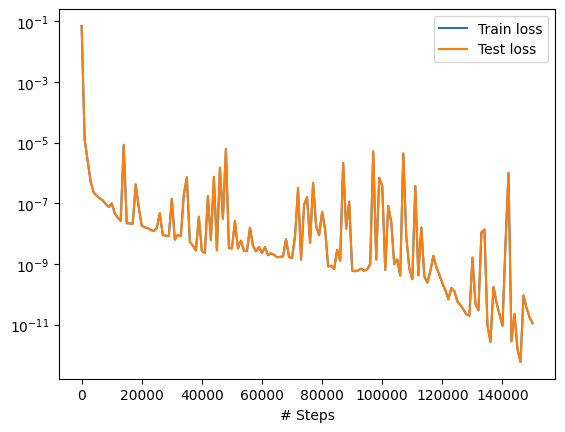

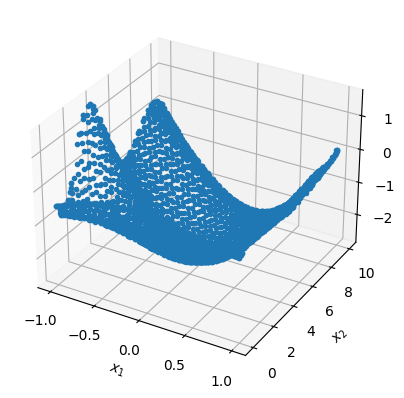

Mean residual: 1.8243953e-06
L2 relative error: 0.9999987155275136


In [9]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

# TODO
#tf.config.run_functions_eagerly(True)
# tf.compat.v1.enable_eager_execution(
#     config=None, device_policy=None, execution_mode=None
# )
# print(f"TF running Eagarly: {tf.executing_eagerly()}")

"""
%% Problem set-up
% Create an interval of the space domain...
dom = [-1,1];
%...and specify a sampling of the time domain:
t = 0:.01:0.99;

"""
geom = dde.geometry.Interval(-1, 1)
# TODO stretch time out as far as possible (10, 100, 1000)
timedomain = dde.geometry.TimeDomain(0.0, 10.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Loads from an external pre-exported dataset
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


"""
% Make the right-hand side of the PDE.
pdefun = @(t,x,u) -u.*diff(u)+0.01./pi.*diff(u,2);

"""
def pde(x, y):
    """
The first argument to pde is 2-dimensional vector where the first component(x[:,0])
is x-coordinate and the second componenet (x[:,1]) is the
t-coordinate. The second argument is the network output, i.e., the solution u(x, t)
, but here we use y as the name of the variable.
    """
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    viscosity = 0.01
    return dy_t + y * dy_x - viscosity / np.pi * dy_xx # TODO add nudged terms.


# Hyperarameter
MU = 0.5

def nudged_pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    viscosity = 0.01
    pde = dy_t + y * dy_x - viscosity / np.pi * dy_xx

    # TODO add nudged terms.
    # U = (u v)
    # (d_t U) * U * (d_x U) - v * (d_x^2 U) + (mu * P_N U_2 - mu * P_N U_1)
    # params = (tf.spectral.rfft(y) - tf.spectral.rfft(x))

    y_complex = tf.cast(
        y, tf.complex64, name=None
    )
    x_complex = tf.cast(
        x, tf.complex64, name=None
    )
    fft_y = tf.math.real(tf.signal.fft(y_complex))
    fft_x = tf.math.real(tf.signal.fft(x_complex))

    if not MU:
        raise("Mu not defined")
    mu = MU

    pde = (dy_t + y * dy_x - viscosity / np.pi * dy_xx) + (mu * fft_y - mu * fft_x)
    return pde


def find_pn1(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    viscosity = 0.01
    pde = dy_t + y * dy_x - viscosity / np.pi * dy_xx

    # TODO add nudged terms.
    # U = (u v)
    # (d_t U) * U * (d_x U) - v * (d_x^2 U) + (mu * P_N U_2 - mu * P_N U_1)
    # params = (tf.spectral.rfft(y) - tf.spectral.rfft(x))

    y_complex = tf.cast(
        y, tf.complex64, name=None
    )
    x_complex = tf.cast(
        x, tf.complex64, name=None
    )
    fft_y = tf.math.real(tf.signal.fft(y_complex))
    fft_x = tf.math.real(tf.signal.fft(x_complex))

    if not MU:
        raise("Mu not defined")
    mu = MU

    # ((d_t U) * U * (d_x U) - v * (d_x^2 U) + mu * P_N U_2)/mu =  P_N U_1

    pde = (dy_t + y * dy_x - viscosity / np.pi * dy_xx)
    pn1 = (pde + mu * fft_y)/mu
    return pn1


def find_pn2(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    viscosity = 0.01
    pde = dy_t + y * dy_x - viscosity / np.pi * dy_xx

    # TODO add nudged terms.
    # U = (u v)
    # (d_t U) * U * (d_x U) - v * (d_x^2 U) + (mu * P_N U_2 - mu * P_N U_1)
    # (pde - mu * PN_U1)/mu = pn2
    # params = (tf.spectral.rfft(y) - tf.spectral.rfft(x))

    y_complex = tf.cast(
        y, tf.complex64, name=None
    )
    x_complex = tf.cast(
        x, tf.complex64, name=None
    )
    fft_y = tf.math.real(tf.signal.fft(y_complex))
    fft_x = tf.math.real(tf.signal.fft(x_complex))

    if not MU:
        raise("Mu not defined")
    mu = MU

    # ((d_t U) * U * (d_x U) - v * (d_x^2 U) + mu * P_N U_2)/mu =  P_N U_1

    pde = (dy_t + y * dy_x - viscosity / np.pi * dy_xx)
    pn2 = (pde - mu * fft_x)/mu
    return pn2


"""
% Assign boundary conditions.
bc.left = 0;
bc.right = 0;

% Construct a chebfun of the space variable on the domain,
x = chebfun(@(x) x, dom);
% and of the initial condition.
u0 = -sin(8*pi*x);



Next, we consider the boundary/initial condition. on_boundary is chosen here to
 use the whole boundary of the computational domain in considered as the boundary condition.
 We include the geomtime space, time geometry created above and on_boundary as the BCs in the
 DirichletBC function of DeepXDE. We also define IC which is the inital condition
 for the burgers equation and we use the computational domain, initial function,
 and on_initial to specify the IC.

"""

# icbc = initial condition Dirichlet boundry condition
bc = dde.icbc.DirichletBC(
    geomtime,
    lambda x: 0,
    lambda _,
    on_boundary:
    on_boundary
)

# TODO: initialze v as zero
ic = dde.icbc.IC(
    geomtime,
    # lambda x: -np.sin(8 * np.pi * x[:, 0:1]), # -sin(8*pi*x)
    lambda x: 0,
    lambda _,
    on_initial: on_initial
)



"""
Now, we have specified the geometry, PDE residual, and boundary/initial condition.
We then define the TimePDE problem as
"""
# https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.fpde.TimeFPDE
data = dde.data.TimePDE(
    geomtime, # TODO how is it generating data for training
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)


pn1_output = dde.callbacks.OperatorPredictor(
    #geom.random_points(2),
    geomtime.random_points(2),
    op=find_pn1,
    period=500,
    filename="pn1.txt"
)

pn2_output = dde.callbacks.OperatorPredictor(
    #geom.random_points(2),
    geomtime.random_points(2),
    op=find_pn2,
    period=500,
    filename="pn2.txt"
)

# Define the DNN
# tanh acivation funciton
# Glorot Normal - initialize network weights
# https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# define the optimiztion and learning rate
# TODO run eagarly
model.compile("adam", lr=1e-3)

iters = 150_000

# trained on generated PDE data
# model.train(iterations=iters, callbacks=[mu_output])
model.train(iterations=iters, callbacks=[pn1_output, pn2_output])


# After we train the network using Adam, we continue to
# train the network using L-BFGS to achieve a smaller loss:
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# TODO: create new test data?!
# Test data
X, y_true = gen_testdata()
y_pred = model.predict(X)

f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))

print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))